In [8]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
import tree
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation
from omegaconf import OmegaConf
import importlib
import logging
import sys

from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from data import r3_diffuser
from data import digs_data_loader
from model import loss
from experiments import train_se3_diffusion

# Enable logging
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

In [9]:
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/home/jyim/Projects/protein_diffusion_v2/experiments/train_se3_diffusion.py'>

In [18]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'digs'

data_conf = conf.data
data_conf.digs.filtering.subset = 1
data_conf.digs.fraction_fb = 0.0

diff_conf = conf.diffuser
diff_conf.rot_schedule = 'linear'
diff_conf.trans_schedule = 'linear'

In [19]:
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, train_sampler, valid_loader, valid_sampler = exp.create_digs_dataset(0, 1)
se3_diff = exp.diffuser
r3_diff = se3_diff._r3_diffuser
so3_diff = se3_diff._so3_diffuser

# Extract a protein backbone.
train_iter = iter(train_loader)
next_item = next(train_iter)
res_mask = next_item['res_mask'][0, :]
ca_pos = next_item['xyz'][0, :, 1, :][res_mask.bool()]

# SDE time parameters
num_t = 100
forward_t = np.linspace(1e-5, 1, num_t)
reverse_t = forward_t[::-1]
dt = 1 / num_t

INFO: Number of model parameters 3488030
INFO: Using cached IGSO3.
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl
INFO: Loaded data at ./pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl


# Translations

In [20]:
# Forward diffusion
x_0 = np.ones((1, 3))
marginal_samples = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    for _ in range(500):
        marginal_samples[i].append(
            r3_diff.forward_marginal(x_0, t)[0])

In [21]:
# Reverse diffusion
reverse_samples = {}
for _ in range(500):
    curr_step = r3_diff.sample_ref(n_samples=1)
    for i, t in reversed(list(enumerate(forward_t))):
        if i not in reverse_samples:
            reverse_samples[i] = []
        score_t = r3_diff.score(
            curr_step,
            x_0,
            t)
        curr_step = r3_diff.reverse(
            x_t=curr_step,
            score_t=score_t,
            t=t,
            dt=dt)
        reverse_samples[i].append(copy.deepcopy(curr_step))

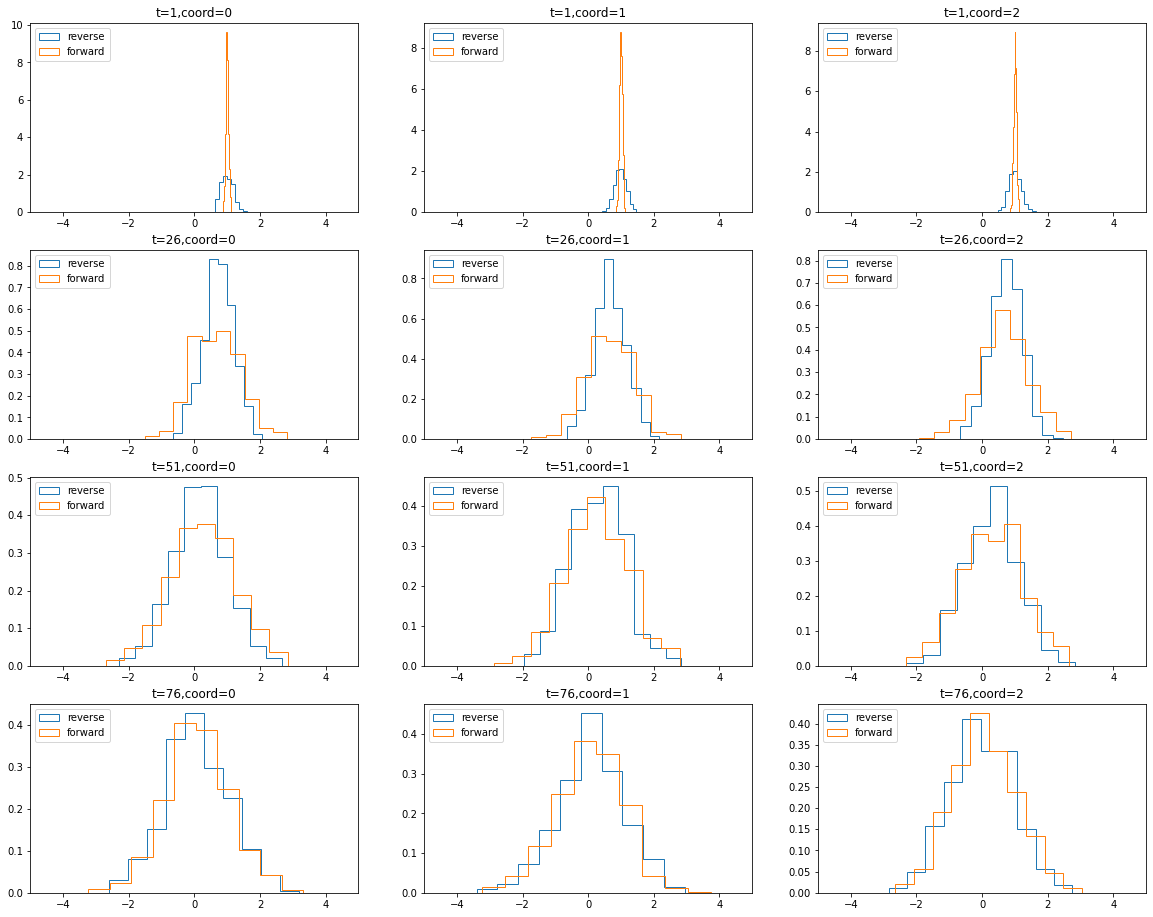

In [22]:
ts = np.arange(1, num_t, num_t//4)
f, axes = plt.subplots(len(ts), 3, figsize=[20, 4*len(ts)])
for i,t in enumerate(ts):
    for j in range(3):
        reverse_i = np.stack(reverse_samples[t])[:, 0, j]
        axes[i, j].hist(reverse_i, bins=10, density=True, label='reverse', histtype='step')

        forward_i = np.stack(marginal_samples[t])[:, 0, j]
        axes[i, j].hist(forward_i, bins=10, density=True, label='forward', histtype='step')

        axes[i, j].set_xlim(-5, 5)
        axes[i, j].set_title(f't={t},coord={j}')
        axes[i, j].legend(loc="upper left")


# Rotations

In [15]:
# Forward diffusion
rot_0 = np.zeros((1, 3))
marginal_samples = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    for _ in range(500):
        marginal_samples[i].append(
            so3_diff.forward_marginal(rot_0, t)[0])

In [16]:
# Reverse diffusion
reverse_samples = {}
for _ in range(500):
    curr_step = so3_diff.sample_ref(n_samples=1)
    for i, t in reversed(list(enumerate(forward_t))):
        if i not in reverse_samples:
            reverse_samples[i] = []
        score_t = so3_diff.score(curr_step, t)
        curr_step = so3_diff.reverse(
            rot_t=curr_step,
            score_t=score_t,
            t=t,
            dt=dt)
        reverse_samples[i].append(copy.deepcopy(curr_step))

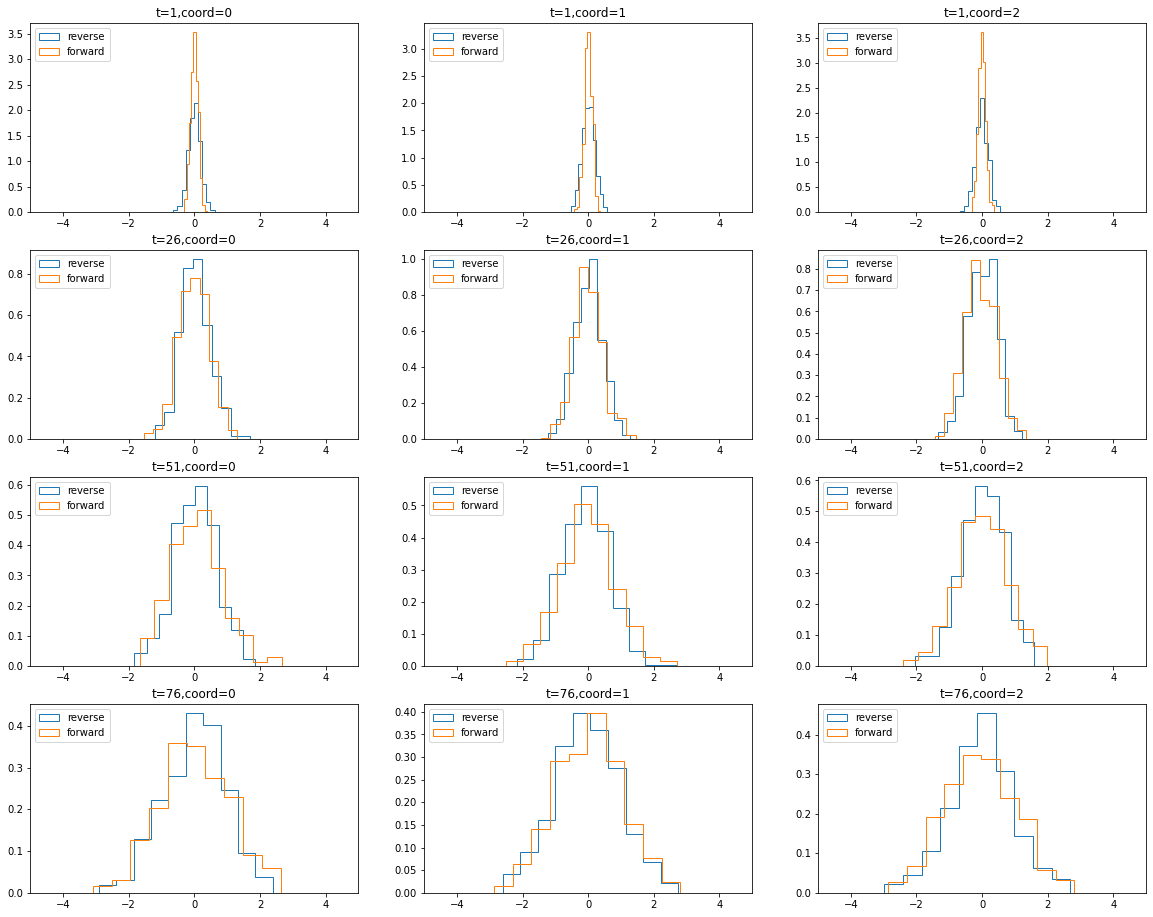

In [17]:
ts = np.arange(1, num_t, num_t//4)
f, axes = plt.subplots(len(ts), 3, figsize=[20, 4*len(ts)])
for i,t in enumerate(ts):
    for j in range(3):
        reverse_i = np.stack(reverse_samples[t])[:, 0, j]
        axes[i, j].hist(reverse_i, bins=10, density=True, label='reverse', histtype='step')

        forward_i = np.stack(marginal_samples[t])[:, 0, j]
        axes[i, j].hist(forward_i, bins=10, density=True, label='forward', histtype='step')

        axes[i, j].set_xlim(-5, 5)
        axes[i, j].set_title(f't={t},coord={j}')
        axes[i, j].legend(loc="upper left")


# Rigid bodies

In [202]:
# Forward diffusion
rigid_0 = ru.Rigid(
    rots=ru.Rotation(
        rot_mats=torch.Tensor(
            Rotation.from_rotvec(
                np.zeros((1, 3))
            ).as_matrix()
        )
    ),
    trans=torch.ones((1, 3))
)
    
marginal_samples = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    for _ in range(500):
        marginal_samples[i].append(
            se3_diff.forward_marginal(rigid_0, t)[0].to_tensor_7())

In [203]:
# Reverse diffusion
reverse_samples = {}
for _ in range(500):
    curr_step = se3_diff.sample_ref(n_samples=1)
    for i, t in reversed(list(enumerate(forward_t))):
        if i not in reverse_samples:
            reverse_samples[i] = []
        trans_score, rot_score = se3_diff.score(rigid_0, curr_step, t)
        curr_step = se3_diff.reverse(
            rigid_t=curr_step,
            rot_score=rot_score,
            trans_score=trans_score,
            t=t,
            dt=dt)
        reverse_samples[i].append(copy.deepcopy(curr_step.to_tensor_7()))

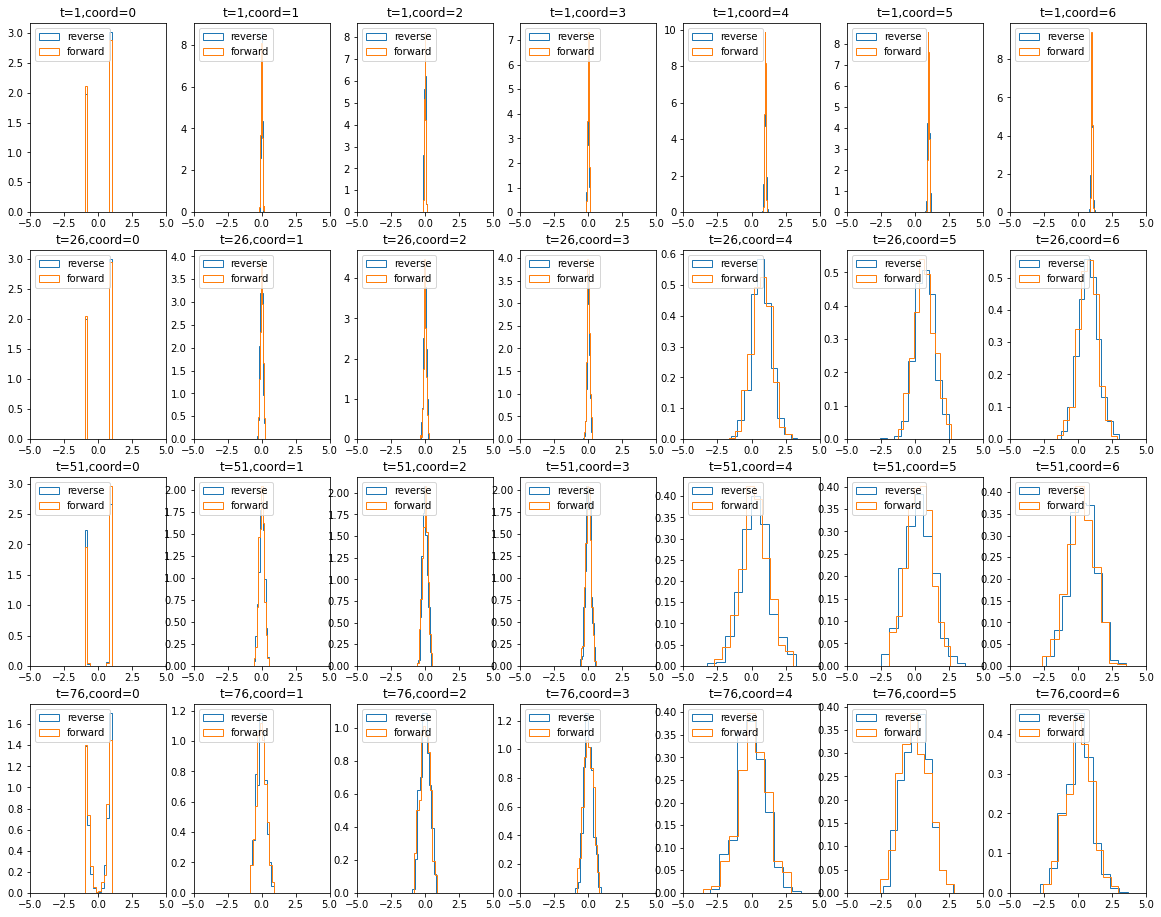

In [204]:
ts = np.arange(1, num_t, num_t//4)
num_coords = 7
f, axes = plt.subplots(len(ts), num_coords, figsize=[20, 4*len(ts)])
for i,t in enumerate(ts):
    for j in range(num_coords):
        reverse_i = np.stack(reverse_samples[t])[:, 0, j]
        axes[i, j].hist(reverse_i, bins=10, density=True, label='reverse', histtype='step')

        forward_i = np.stack(marginal_samples[t])[:, 0, j]
        axes[i, j].hist(forward_i, bins=10, density=True, label='forward', histtype='step')

        axes[i, j].set_xlim(-5, 5)
        axes[i, j].set_title(f't={t},coord={j}')
        axes[i, j].legend(loc="upper left")
